# Application with new features!

In [2]:
import os
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from knnxkde import KNNxKDE
from utils import normalization, renormalization
from utils import convolution_TLG2020_only_msini

## 0. Prepare matrix

- Load data
- Remove mass if not observed mass
- Select subset of feature for imputation
- Transform log

In [3]:
original_df = pd.read_csv('data/exoplanets2023.csv')

my_df = original_df.copy()
for n in range(len(my_df)):
    if my_df.loc[n, 'pl_bmassprov'] == 'Msini':
        my_df.loc[n, 'pl_bmassj'] = np.nan
    if my_df.loc[n, 'pl_orbeccen']<0.0:
        my_df.loc[n, 'pl_orbeccen'] = 0  # Remove the 3 suspicious values 

In [4]:
ALL_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_orbincl',
    'pl_eqt',
    'st_mass',
    'st_met',
    'st_age',
    'sy_snum',
    'sy_pnum'
]

NEW_FEATURES = [
    'pl_radj',
    'pl_bmassj',
    'pl_orbper',
    'pl_orbeccen',
    'pl_eqt',
    'st_mass',
    'st_met',
    'sy_pnum',
]

In [5]:
X = np.array(my_df[NEW_FEATURES])
X[:, [0, 1, 2, 4, 5]] = np.log(X[:, [0, 1, 2, 4, 5]])

<Figure size 288x288 with 0 Axes>

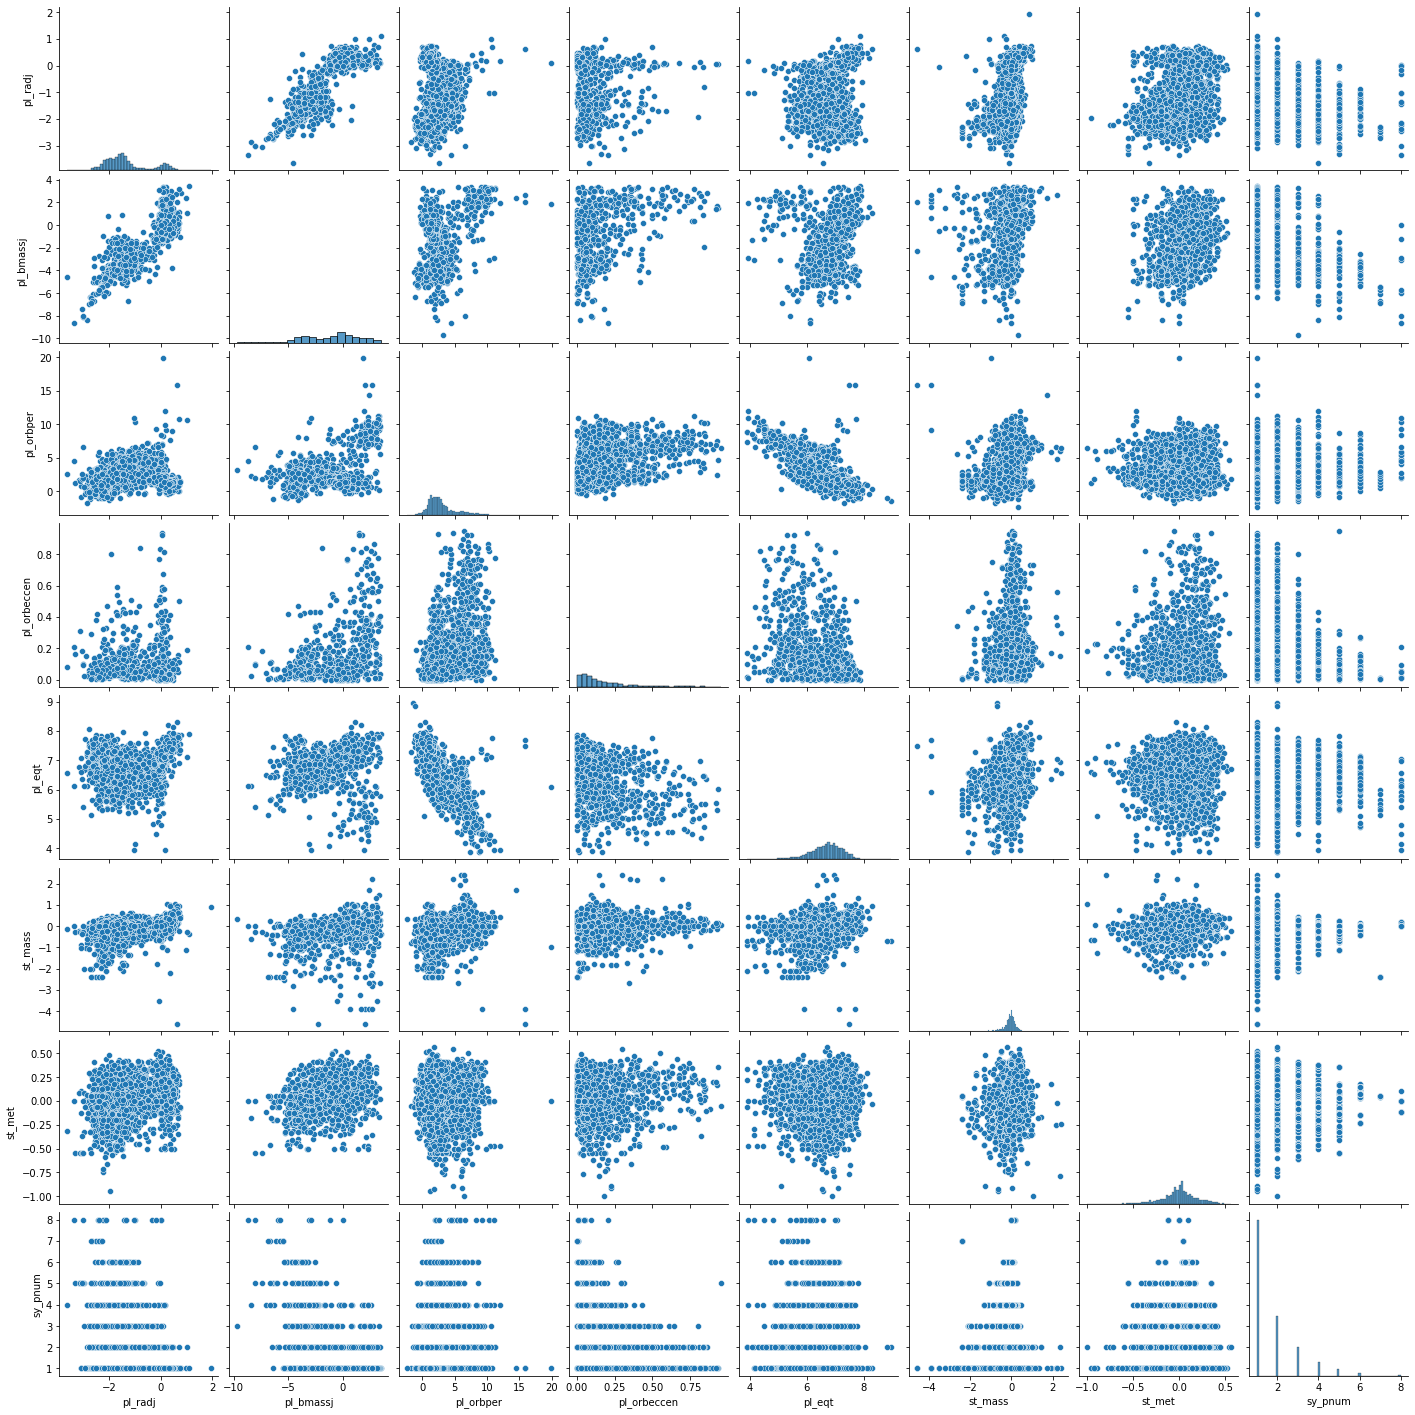

In [17]:
X_df = pd.DataFrame(X, columns=NEW_FEATURES)
plt.figure(figsize=(4, 4))
sns.pairplot(X_df)
plt.savefig('temp_pairplot2.pdf')
plt.show()

## 1. Impute everyone!

In [5]:
MY_TAU = 1.0 / 50.0
MY_NB_NEIGH = 20
knnxkde = KNNxKDE(h=0.05, tau=MY_TAU, nb_neigh=MY_NB_NEIGH, metric='nan_std_eucl')

In [6]:
miss_data = np.copy(X)
norm_miss_data, norm_params = normalization(miss_data)

In [7]:
RJ = 11.21  # in Earth radii
MJ = 317.8  # in Earth masses
r1, m1 = norm_params['min_val'][:2]
r2, m2 = norm_params['max_val'][:2]
my_rad_bins = np.geomspace(1e-1, 1e2, num=101)
my_mass_bins = np.geomspace(1e-1, 1e5, num=101)
N, D = norm_miss_data.shape

In [8]:
NB_DRAWS = 10000
imputation_samples = knnxkde.impute_samples(norm_miss_data, nb_draws=NB_DRAWS)

## 2. Super plots!

Plot and save 5,200+ histograms...  
/!\ Only run the for loop below if necessary /!\

In [9]:
def generate_planet_bio(n):
    cur_data = my_df.iloc[n]
    pl_rade = cur_data['pl_radj'] * RJ  # radius in Earth radii
    pl_masse = cur_data['pl_bmassj'] * MJ  # mass in Earth masses
    pl_orbper = cur_data['pl_orbper']  # in days
    pl_orbeccen = cur_data['pl_orbeccen']  # e \in [0, 1]
    pl_teq = cur_data['pl_eqt']  # in K
    st_mass = cur_data['st_mass']  # in Solar masses
    st_met = cur_data['st_met']  # in dex
    pl_pnum = cur_data['sy_pnum']
    my_text = fr'Rad. = {pl_rade:.3f} $r_\oplus$' + '\n'
    my_text += fr'Mass = {pl_masse:.3f} $m_\oplus$' + '\n'
    my_text += fr'OrbPer = {pl_orbper:.2f} days' + '\n'
    my_text += fr'OrbEcc. = {pl_orbeccen:.3f}' + '\n'
    my_text += fr'T.Eq. = {pl_teq:.0f} K' + '\n'
    my_text += fr'StMass = {st_mass:.3f} $m_\odot$' + '\n'
    my_text += fr'StMet. = {st_met:.3f} dex' + '\n'
    my_text += fr'Nb. Pl. = {pl_pnum}'
    return my_text

In [10]:
for n in range(N):
    if (n+1)%100==0:
        print(f'{n+1}/{N}  --> ', time.strftime("%Y-%m-%d %H:%M:%S"))
    print(f'{n+1}/{N}', end='\r')
    unif_weights = np.ones(NB_DRAWS) / NB_DRAWS
    weights = np.full(NB_DRAWS, np.nan)
    rad_distrib = np.full(NB_DRAWS, np.nan)
    valid_r = np.full(NB_DRAWS, np.nan)
    rad_estimate = np.nan
    mass_distrib = np.full(NB_DRAWS, np.nan)
    valid_m = np.full(NB_DRAWS, np.nan)
    mass_estimate = np.nan
    msini = np.nan
    
    if np.isnan(norm_miss_data[n, 0]):
        rad_distrib = np.exp(imputation_samples[(n, 0)] * (r2 + 1e-6) + r1)
        
        if np.isnan(norm_miss_data[n, 1]):  # BOTH RADIUS AND MASS MISSING
            mass_distrib = np.exp(imputation_samples[(n, 1)] * (m2 + 1e-6) + m1)
            if original_df.iloc[n]['pl_bmassprov']=='Msini':  # if m*sin(i) is available
                msini = original_df.iloc[n]['pl_bmassj']  # m*sin(i) in Jupiter masses
                valid_r, valid_m, weights = convolution_TLG2020_only_msini(rad_distrib, mass_distrib, msini)
                rad_estimate = np.nansum(valid_r * weights)
                mass_estimate = np.nansum(valid_m * weights)
            else:
                rad_estimate = np.exp(np.mean(np.log(rad_distrib)))
                mass_estimate = np.exp(np.mean(np.log(mass_distrib)))
        
        else:  # JUST RADIUS MISSING
            rad_estimate = np.exp(np.mean(np.log(rad_distrib)))
    
    elif np.isnan(norm_miss_data[n, 1]):  # JUST MASS MISSING
        mass_distrib = np.exp(imputation_samples[(n, 1)] * (m2 + 1e-6) + m1)
        if original_df.iloc[n]['pl_bmassprov']=='Msini':  # and if m*sin(i) is available
            msini = original_df.iloc[n]['pl_bmassj']  # m*sin(i) in Jupiter masses
            valid_m, valid_m, weights = convolution_TLG2020_only_msini(mass_distrib, mass_distrib, msini)
            mass_estimate = np.nansum(valid_m * weights)
        else:
            mass_estimate = np.exp(np.mean(np.log(mass_distrib)))
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    
    ax[0].hist(rad_distrib*RJ, weights=unif_weights, bins=my_rad_bins, color='C3', alpha=0.5)
    temp_ylim = ax[0].get_ylim()
    ax[0].hist(valid_r*RJ, weights=weights, bins=my_rad_bins, color='saddlebrown', alpha=0.5)
    ax[0].axvline(rad_estimate*RJ, ls=(0, (4, 3)), lw=2, color='saddlebrown')
    ax[0].set_xscale('log')
    ax[0].set_xlabel('Radius [r$_\oplus$]')
    ax[0].set_ylabel('Proportion')
    ax[0].set_ylim(temp_ylim)

    ax[1].hist(mass_distrib*MJ, weights=unif_weights, bins=my_mass_bins, color='C3', alpha=0.5)
    temp_ylim = ax[1].get_ylim()
    ax[1].hist(valid_m*MJ, weights=weights, bins=my_mass_bins, color='saddlebrown', alpha=0.5)
    ax[1].axvline(msini*MJ, ls='-', lw=2, color='black', alpha=0.6)
    ax[1].axvline(mass_estimate*MJ, ls=(0, (4, 3)), lw=2, color='saddlebrown')
    ax[1].set_xscale('log')
    ax[1].set_xlabel('Mass [m$_\oplus$]')
    ax[1].set_ylabel('Proportion')
    ax[1].set_ylim(temp_ylim)
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.1)
    ax[0].text(1.02, 0.98, generate_planet_bio(n), transform=ax[0].transAxes, fontsize=10, verticalalignment='top', bbox=props)
    ax[0].set_title(original_df.iloc[n]['pl_name'], size=14)
    fig.tight_layout()
    plt.savefig(f'results_and_figures/4_application_extra/distrib_{str(n).zfill(4)}.pdf')
    plt.close()

100/5251  -->  2023-09-11 18:36:27
200/5251  -->  2023-09-11 18:38:25
300/5251  -->  2023-09-11 18:40:29
400/5251  -->  2023-09-11 18:42:28
500/5251  -->  2023-09-11 18:44:29
600/5251  -->  2023-09-11 18:46:29
700/5251  -->  2023-09-11 18:48:36
800/5251  -->  2023-09-11 18:50:49
900/5251  -->  2023-09-11 18:52:40
1000/5251  -->  2023-09-11 18:54:57
1100/5251  -->  2023-09-11 18:56:49
1200/5251  -->  2023-09-11 19:00:01
1300/5251  -->  2023-09-11 19:01:52
1400/5251  -->  2023-09-11 19:06:38
1500/5251  -->  2023-09-11 19:08:31
1600/5251  -->  2023-09-11 19:10:23
1700/5251  -->  2023-09-11 19:15:21
1800/5251  -->  2023-09-11 19:17:14
1900/5251  -->  2023-09-11 19:19:06
2000/5251  -->  2023-09-11 19:20:58
2100/5251  -->  2023-09-11 19:27:33
2200/5251  -->  2023-09-11 19:29:25
2300/5251  -->  2023-09-11 19:31:18
2400/5251  -->  2023-09-11 19:33:11
2500/5251  -->  2023-09-11 19:41:53
2600/5251  -->  2023-09-11 19:43:51
2700/5251  -->  2023-09-11 19:45:43
2800/5251  -->  2023-09-11 19:47:35
2